**Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Libraries**

In [ ]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import cv2

**Code**

In [ ]:
class VGG16(nn.Module):
    def __init__(self, in_channels=3, num_classes=3):
        super(VGG16, self).__init__()

        # Define the VGG16 convolutional layers
        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Define the fully connected layers
        self.fcs = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fcs(x)
        return x

In [ ]:
# Hyperparameters
num_classes = 3
batch_size = 64
learning_rate = 0.001
num_epochs = 30

# # Transforms and Dataset
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
# ])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
# Set up your own dataset paths (adjust the paths as needed)
train_dir = "/content/drive/MyDrive/Practice/datasets/train"
valid_dir = "/content/drive/MyDrive/Practice/datasets/valid"
test_dir = "/content/drive/MyDrive/Practice/datasets/test"

# Load the datasets using ImageFolder (expects data organized in subfolders for each class)
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
valid_dataset = datasets.ImageFolder(root=valid_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create DataLoader objects to handle batching and shuffling
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Print total number of images in train, validation, and test datasets
print(f"Total training images: {len(train_dataset)}")
print(f"Total validation images: {len(valid_dataset)}")
print(f"Total testing images: {len(test_dataset)}")

Total training images: 1500
Total validation images: 900
Total testing images: 600


In [ ]:
# Print class names (to be used during inference and visualization)
class_names = train_dataset.classes
print(f"Class names: {class_names}")

Class names: ['cats', 'dogs', 'snakes']


In [ ]:
# Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16(in_channels=3, num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

**Train**

In [ ]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, targets)
            running_train_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)

                # Forward pass
                outputs = model(data)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Print losses for the epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.2f}, Validation Loss: {avg_val_loss:.2f}")

    return train_losses, val_losses

In [ ]:
# Train and validate
train_losses, val_losses = train_and_validate(
    model=model,
    train_loader=train_loader,
    val_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

Epoch [1/30] - Train Loss: 1.12, Validation Loss: 1.10
Epoch [2/30] - Train Loss: 1.10, Validation Loss: 1.10
Epoch [3/30] - Train Loss: 1.10, Validation Loss: 1.10
Epoch [4/30] - Train Loss: 1.10, Validation Loss: 1.10
Epoch [5/30] - Train Loss: 1.10, Validation Loss: 1.10
Epoch [6/30] - Train Loss: 1.10, Validation Loss: 1.10
Epoch [7/30] - Train Loss: 1.10, Validation Loss: 1.10
Epoch [8/30] - Train Loss: 1.10, Validation Loss: 1.10
Epoch [9/30] - Train Loss: 1.10, Validation Loss: 1.10
Epoch [10/30] - Train Loss: 1.10, Validation Loss: 1.10
Epoch [11/30] - Train Loss: 1.10, Validation Loss: 1.10
Epoch [12/30] - Train Loss: 1.10, Validation Loss: 1.10
Epoch [13/30] - Train Loss: 1.10, Validation Loss: 1.10
Epoch [14/30] - Train Loss: 1.10, Validation Loss: 1.10
Epoch [15/30] - Train Loss: 1.10, Validation Loss: 1.10
Epoch [16/30] - Train Loss: 1.10, Validation Loss: 1.10
Epoch [17/30] - Train Loss: 1.10, Validation Loss: 1.10
Epoch [18/30] - Train Loss: 1.10, Validation Loss: 1.10
E

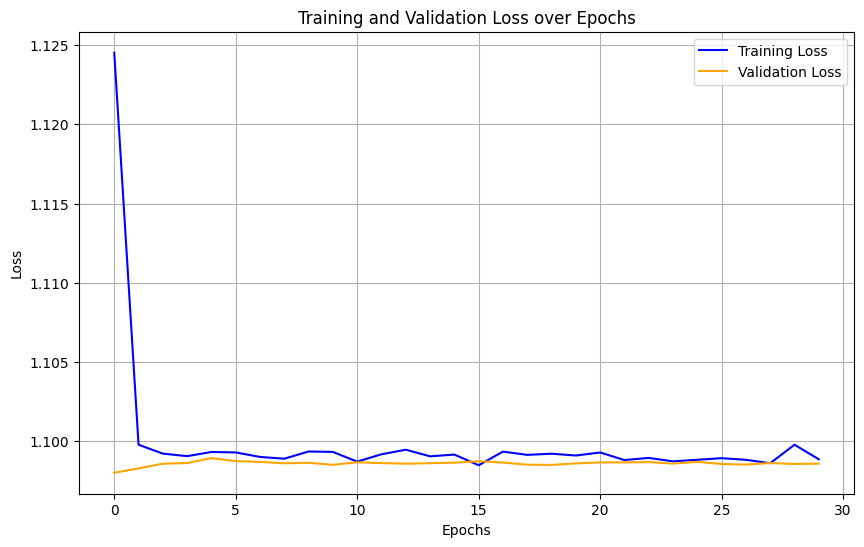

In [ ]:
# Plotting the losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss", color='blue')
plt.plot(val_losses, label="Validation Loss", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

**Save/Load Model Weights**

In [ ]:
# Save model weights
model_save_path = "/content/model_weights.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

# # Load model weights (when needed)
# model.load_state_dict(torch.load(model_save_path))
# model.to(device)
# print(f"Model weights loaded from {model_save_path}")

Model weights saved to /content/model_weights.pth


**Testing**

In [ ]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    running_test_loss = 0.0

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, targets)
            running_test_loss += loss.item()

    avg_test_loss = running_test_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss:.2f}")
    return avg_test_loss

In [ ]:
# Test the model
test_loss = test_model(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=device
)

print(f"Final Test Loss: {test_loss:.2f}")

Test Loss: 1.10
Final Test Loss: 1.10


In [ ]:
# Saving test result in CSV File
# import pandas as pd
# import os

# def test_model(model, test_loader, criterion, device, csv_save_path="test_results.csv"):
#     model.eval()
#     test_loss = 0.0
#     all_targets = []
#     all_preds = []
#     all_probs = []

#     with torch.no_grad():
#         for data, targets in test_loader:
#             data, targets = data.to(device), targets.to(device)

#             # Forward pass
#             outputs = model(data)
#             loss = criterion(outputs, targets)
#             test_loss += loss.item()

#             # Predictions and probabilities
#             _, predicted = outputs.max(1)
#             all_targets.extend(targets.cpu().numpy())
#             all_preds.extend(predicted.cpu().numpy())
#             all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

#     avg_test_loss = test_loss / len(test_loader)

#     # Save results to CSV
#     results = []
#     for idx, (target, pred, probs) in enumerate(zip(all_targets, all_preds, all_probs)):
#         result = {
#             "Index": idx + 1,
#             "True Class": target,
#             "Predicted Class": pred,
#             "Class Probabilities": ", ".join([f"{prob:.2f}" for prob in probs])
#         }
#         results.append(result)

#     # Create directory if it doesn't exist
#     os.makedirs(os.path.dirname(csv_save_path), exist_ok=True)

#     # Save to CSV
#     df = pd.DataFrame(results)
#     df.to_csv(csv_save_path, index=False)
#     print(f"Test results saved to {csv_save_path}")

#     return avg_test_loss

# # Testing phase
# test_loss = test_model(
#     model=model,
#     test_loader=test_loader,
#     criterion=criterion,
#     device=device,
#     csv_save_path="content/test_results.csv"
# )

# print(f"Test Loss: {test_loss:.2f}")

**Accuracy**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

def test_model_with_metrics(model, test_loader, criterion, device):
    model.eval()
    running_test_loss = 0.0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, targets)
            running_test_loss += loss.item()

            # Get predictions and true labels
            _, predicted = outputs.max(1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    avg_test_loss = running_test_loss / len(test_loader)

    # Compute metrics
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_targets, all_predictions)
    class_report = classification_report(all_targets, all_predictions)

    print(f"Test Loss: {avg_test_loss:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

    return avg_test_loss, precision, recall, f1, conf_matrix, class_report

In [ ]:
# Evaluate the model on the test set
test_loss, precision, recall, f1, conf_matrix, class_report = test_model_with_metrics(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=device
)

# Print final results
print(f"Final Test Metrics:\n"
      f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

Test Loss: 1.10
Precision: 0.11
Recall: 0.33
F1 Score: 0.17

Confusion Matrix:
[[  0 200   0]
 [  0 200   0]
 [  0 200   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.33      1.00      0.50       200
           2       0.00      0.00      0.00       200

    accuracy                           0.33       600
   macro avg       0.11      0.33      0.17       600
weighted avg       0.11      0.33      0.17       600

Final Test Metrics:
Precision: 0.11, Recall: 0.33, F1 Score: 0.17


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

**ROPC-AUC Curve**

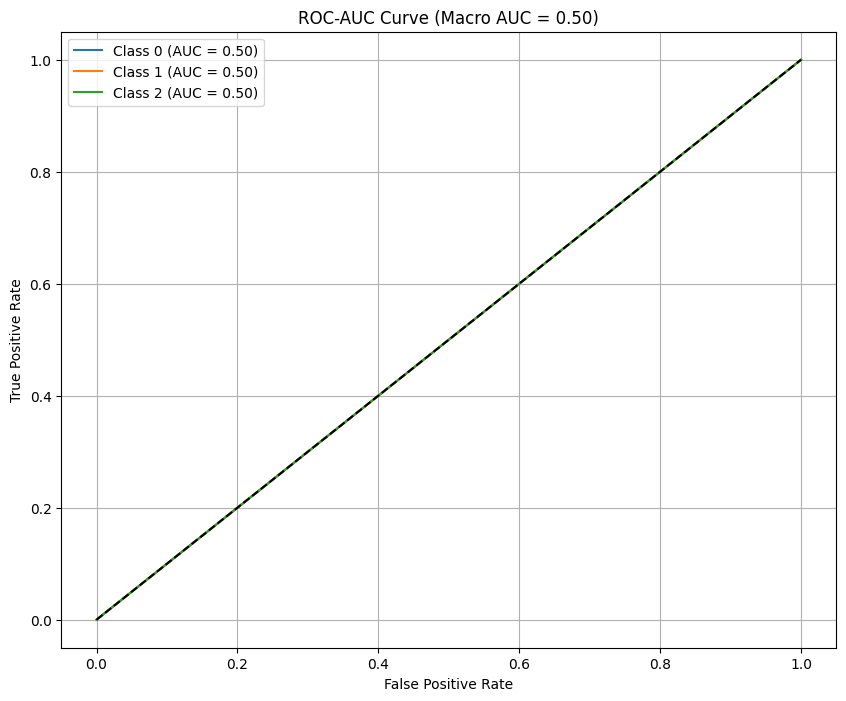

Test Loss: 1.0990
ROC-AUC Scores:
Class 0: 0.5000
Class 1: 0.5000
Class 2: 0.5000
Macro Average: 0.5000
Final Test Loss: 1.0990


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc

def test_model_with_roc_auc(model, test_loader, criterion, device, num_classes):
    model.eval()
    running_test_loss = 0.0
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, targets)
            running_test_loss += loss.item()

            # Get probabilities and true labels
            all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    avg_test_loss = running_test_loss / len(test_loader)

    # One-hot encode targets for ROC-AUC calculation
    all_targets_one_hot = np.zeros((len(all_targets), num_classes))
    all_targets_one_hot[np.arange(len(all_targets)), all_targets] = 1

    # Calculate ROC-AUC scores and plot ROC curves
    roc_auc_scores = {}
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_targets_one_hot[:, i], np.array(all_probs)[:, i])
        roc_auc = auc(fpr, tpr)
        roc_auc_scores[f"Class {i}"] = roc_auc
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    # Compute macro-average ROC-AUC
    macro_roc_auc = roc_auc_score(all_targets_one_hot, np.array(all_probs), multi_class='ovr', average='macro')
    roc_auc_scores["Macro Average"] = macro_roc_auc

    # Plot diagonal for reference
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC-AUC Curve (Macro AUC = {macro_roc_auc:.2f})")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

    print(f"Test Loss: {avg_test_loss:.4f}")
    print("ROC-AUC Scores:")
    for class_name, score in roc_auc_scores.items():
        print(f"{class_name}: {score:.4f}")

    return avg_test_loss, roc_auc_scores

# Evaluate the model on the test set with ROC-AUC plotting
test_loss, roc_auc_scores = test_model_with_roc_auc(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=device,
    num_classes=num_classes
)

# Print final results
print(f"Final Test Loss: {test_loss:.4f}")

**Inference**

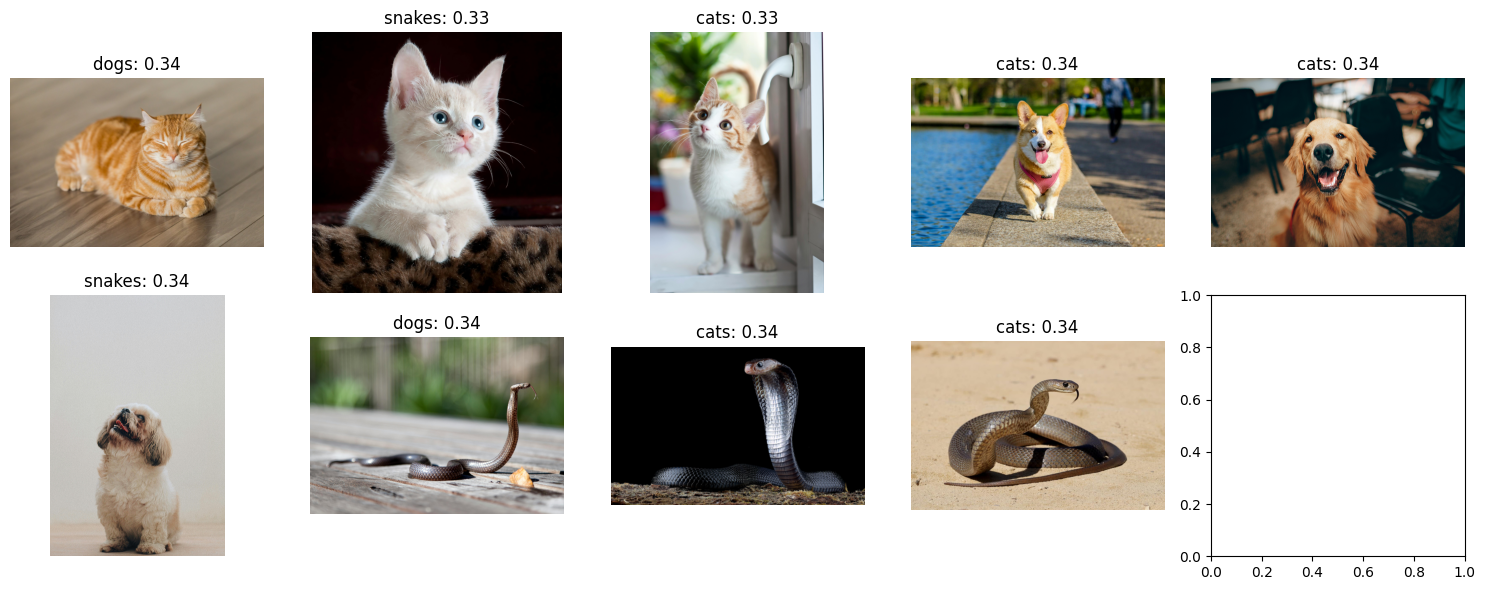

Results saved to 'inference_results.csv'
   Image Predicted Class  Confidence
0  1.jpg            dogs    0.335644
1  2.jpg          snakes    0.333616
2  3.jpg            cats    0.334707
3  4.jpg            cats    0.336519
4  5.jpg            cats    0.340004
5  6.jpg          snakes    0.337711
6  7.jpg            dogs    0.344015
7  8.jpg            cats    0.339424
8  9.jpg            cats    0.337243


In [ ]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
import pandas as pd

def infer_and_visualize(model, folder_path, class_names, device):
    """
    Perform inference on all images in the given folder, visualize them,
    and save the results in a CSV file.
    """
    # Define the transformation for the images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match the model input
        transforms.ToTensor(),         # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    # Prepare a list to store the results
    results = []

    # Prepare a plot for visualizing the images
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Adjust grid as needed
    axes = axes.flatten()

    # Loop through all files in the folder
    for i, image_name in enumerate(os.listdir(folder_path)):
        image_path = os.path.join(folder_path, image_name)

        # Only process image files (optional)
        if image_name.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):
            # Load the image
            image = Image.open(image_path).convert("RGB")
            input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

            # Perform inference
            with torch.no_grad():
                outputs = model(input_tensor)
                probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
                predicted_class = np.argmax(probabilities, axis=1)[0]
                confidence = probabilities[0, predicted_class]

            # Append the result to the list
            results.append({
                "Image": image_name,
                "Predicted Class": class_names[predicted_class],
                "Confidence": confidence
            })

            # Display the image and prediction
            ax = axes[i]
            ax.imshow(image)
            ax.set_title(f"{class_names[predicted_class]}: {confidence:.2f}")
            ax.axis('off')

        # Break if more than 10 images (adjust grid if necessary)
        if i == 9:
            break

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Create a DataFrame to save the results
    results_df = pd.DataFrame(results)

    # Save results to a CSV file
    results_df.to_csv('/content/inference_results.csv', index=False)
    print(f"Results saved to 'inference_results.csv'")

    return results_df

# Extract class names dynamically from train_loader (assuming class names are stored in dataset)
class_names = train_loader.dataset.classes

# Folder path containing the images
folder_path = "/content/drive/MyDrive/Practice/gyan"

# Path to the saved model
model_path = "/content/model_weights.pth"

# Load the model
model = VGG16(num_classes=len(class_names))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.load_state_dict(torch.load(model_path))
model.load_state_dict(torch.load(model_path, weights_only=True))
model.to(device)

# Perform inference and visualize images
results_df = infer_and_visualize(model, folder_path, class_names, device)

# Output the results
print(results_df)